# Building Tensorflow Image Pipeline - tf.keras.utils

This page is part of the `Building Tensorflow Image Pipeline` series.

## Introduction

A major part in the bring up of any Neural Network, besides setting the model itself, is the setting of an efficient data pipeline.

The costruction of input data pipeline is an Extract, Transform, Load (ETL) task, where since our focus here is on image networks, the source data for the Extraction task will commonly be either conventional Image Files, or a TFRecord format saved data, (this is the data saved format when using tf.tfds.load), or any any other plane data format such as numpy array or Image.PIL data.
The Transform task relates to the data adaptation tasks required such as data batching, normalizing, resizing, shuffling, augmentating, and so forth.
The Load task is the insertion of the resultant data into the model.

This series of post presents a variety of imagedata pipeline preparation approches, all aim to provide efficient, multiprocessing capeable, yet simple processing forms.

Just a subnote - basically Tensorflow networks **do** accept Numpy data as input. However, the approaches aim is to achieve an efficient,distributed processing pipeline which requires the proposed arrangements.

The posts of this series are: 

1. **tf.keras.utils** **(This post)**

2. tf.keras.preprocessing.image

3. tf.data

4. tf.tfds


In the following we will go step by step through a data classification code, demonstrating dataset creation using the tf.keras.preprocessing.image module.

Code components are:

1. **Import Packages**

2. **Download the data**

3. **Create the dataset** - (Extract and Transform)

4. **Configure the dataset for performance** - (Transform)

5. **Set the model**

6. **Compile the Model**

7. **Train**

8. **Display Model Summary** 

9. **Visualize Training Results***

10. **Run Inference**


...Here we go...!



## 1. Import Packages

In [88]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers

## 2. Download the data

***Rock Paper Scissors***
We will use the `Rock Paper Scissors` dataset, listed in [TensorFlow Datasets catalog](https://www.tensorflow.org/datasets/catalog/overview). The dataset was produced by [Lawrance Moroney](https://laurencemoroney.com/datasets.html), million thanks for him on that.

***Downloaded Data Format***

Here we download the dataset, which is packed as a .zip file. (Included in the Tensorflow Dataset Catalog, this dataset can be loaded using ***tfds.load*** , a convinience wrapper of tf.data module. Still, ***tfds.load*** can be deployed for Tensorflow Dataset only. One of the posts of this series demonstrate that approach.


In [89]:
import pathlib
dataset_name = 'rps'
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, fname=dataset_name+'.zip', extract=True)

dataset_file point on downloaded file:

In [90]:
print(dataset_file)

/root/.keras/datasets/rps.zip


The downloaded zip file file was extracted , due to the `extract=True` attribute.

Let's examine the zip file and the extracted directory: 

In [91]:
import os
dataset_dir = pathlib.Path(os.path.dirname(os.path.abspath(dataset_file)))
!ls $dataset_dir

rps  rps-test-set  rps_test.zip  rps.zip


#### Each dataset subdirectory to a data class: paper  rock  scissors. Here's the subdirectory list:


In [92]:
class_names = [f for f in os.listdir(os.path.join(dataset_dir, dataset_name))]
print(class_names)

['paper', 'rock', 'scissors']


The zip file downloaded so far holds the `training` data. 

The dataset's author composed another zip file which holds the `test` data. 

Next download it:

In [93]:
dataset_test_name = 'rps_test'
dataset_test_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
dataset_test_file = tf.keras.utils.get_file(origin=dataset_test_url, fname=dataset_test_name+'.zip', extract=True)

The `train` and `test` datasection are split 80-20. That is fine. but for methodical reasons, The straight forward way to do is to take them as is for training and validation respectively. Methodicaly, we will merge the 2, just to demonstrate the split capabilities of the method which follows in the next section.

In [94]:
!cp -r /root/.keras/datasets/rps-test-set/* /root/.keras/datasets/rps

Let's check how much data have we got by counting number of files in each class directory

In [95]:
from os import listdir
from os.path import isfile, join
import os

class_dir_info = {}
file_ext = 'png'

base_data_dir = os.path.join(dataset_dir, 'rps')
for class_name in class_names:
  subdir = pathlib.Path(os.path.join(base_data_dir, class_name))
  import os, random
  files_count = len([file for file in os.listdir(subdir) if file.endswith(file_ext)])
  class_dir_info.update({'dir': subdir})
  print('{}: {} files'.format(class_name, files_count))

print('total file count: {}'.format(len(list(pathlib.Path(base_data_dir).glob('*/*.{}'.format(file_ext))))))

paper: 964 files
rock: 964 files
scissors: 964 files
total file count: 2892


***Visualization*** - take a brief look at randomly selected images from each class

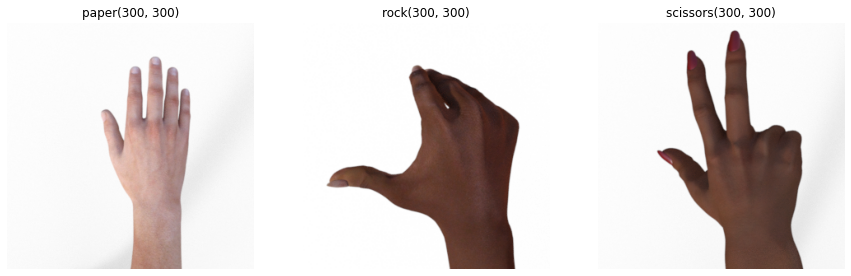

In [96]:
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(class_names):
  path = pathlib.Path(os.path.join(base_data_dir, class_name))
  filename =random.choice(os.listdir(path))
  ax = plt.subplot(1, len(class_names), i + 1)
  im = PIL.Image.open(os.path.join(path, filename))
  plt.imshow(im)
  plt.axis("off")
  plt.title(class_names[i]+str(im.size))

## 3. Create the dataset (Extract + Transform)

Having downloaded and extracted the source data files, we we start the creation of data pipeline. 
In this post example, we use the `tf.keras.utils.image_dataset_from_directory` method.
Important note - the data pipeline operates in the graph mode - see details in the corresponding post (TBD). Accordingly, we first construct the graph which later be triggered with data.


In [97]:
batch_size = 32
image_height = 180
image_width = 180

Create training dataset:

In [98]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=base_data_dir, 
  labels="inferred", 
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  shuffle=True, # shuffle is default anyways...
  batch_size=batch_size)

Found 2892 files belonging to 3 classes.
Using 2314 files for training.


Notes on some of the above attributes:

- `directory`: is where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored

- `labels`='inferred' (default). This assumes that the labels are generated from the directory structure.

- `validation_split`: 20% of the dataset is assigned to validation, while the other 80% for training.

- `subset`: This field must be either `training` or `testing`. If `subset` is set, `validation_split` must be set, and inversely.

- `batch_size`: Default 32

- `image size` Image dimenssions are set to 180x180. (Constraint - each dimenssion should be a multiple of 16, since model contains 4 pooling modules, each downsizes both dimenssions by a factor of 2)

- `color_mode`=`rgb` (default)



**Note** that the method transparently supports various image formats, so we need not decode jpeg images. Supported image formats: jpeg, png, bmp, gif, where
Animated gifs are truncated to the first frame.

In [99]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


Similarly, create the validation set 

In [100]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=base_data_dir, 
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 2892 files belonging to 3 classes.
Using 578 files for validation.


#### Take some methodical observations:

A Dataset element comprizes of a 180x180x3 float32 image and a float32 label

In [101]:
train_ds.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Examine a single batches shapes:

In [102]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 4. Configure the dataset for performance. (Transform)

The dataset Some data transformations were already defined executed by `image_dataset_from_directory`. That includes batching, image format decoding, splitting and resizing.

Next we will define more essential transformations:

- Dataset.cache keeps the images in memory after they're loaded off disk during 
the first epoch. 

- Dataset.prefetch overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent).




**Cache**, **Shuffle** (train data only) and **Prefetch**:

In [103]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Normalize range** of data values to [0,1]

In [104]:
normalization_layer = layers.Rescaling(1./255)

In [105]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

**Data Augmentation** - Expand training dataset size

(Find details on Data Augmentation in a related post (TBD))

In [106]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.9, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

**Demonstrate Augmentation Visualization**: 

Original image is at upper left, with 8 randomly augmented images. 

Note that dataset is exended to be 4 dims, as expected by the augmentation methods.


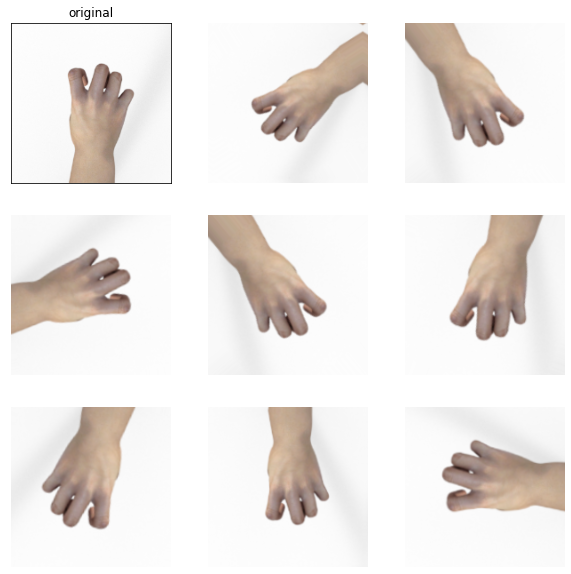

In [107]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]
  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  plt.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])

  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

Set Augmentation to training dataset

In [108]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

## 5. Set the model

The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scizors.


In [109]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,  activation = 'softmax')
])

<a name='5'></a>
## 6. Compile the Model

- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7. Train the model

Set an Early Stopping Callback

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [111]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [113]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


73/73 [==============================] - 26s 227ms/step - loss: 1.0689 - accuracy: 0.3993 - val_loss: 1.0232 - val_accuracy: 0.5208
Epoch 2/30
73/73 [==============================] - 16s 215ms/step - loss: 0.7804 - accuracy: 0.6400 - val_loss: 0.4691 - val_accuracy: 0.8235
Epoch 3/30
73/73 [==============================] - 16s 213ms/step - loss: 0.6200 - accuracy: 0.7264 - val_loss: 0.4755 - val_accuracy: 0.8201
Epoch 4/30
73/73 [==============================] - 16s 214ms/step - loss: 0.4597 - accuracy: 0.8194 - val_loss: 0.3839 - val_accuracy: 0.8702
Epoch 5/30
73/73 [==============================] - 16s 214ms/step - loss: 0.3636 - accuracy: 0.8717 - val_loss: 0.2027 - val_accuracy: 0.9429
Epoch 6/30
73/73 [==============================] - 16s 214ms/step - loss: 0.2866 - accuracy: 0.8941 - val_loss: 0.3067 - val_accuracy: 0.8824
Epoch 7/30
73/73 [==============================] - 16s 216ms/step - loss: 0.2205 - accuracy: 0.9201 - val_loss: 0.1249 - val_accuracy: 0.9619
Epoch 8/30

## 8. Display model summary

In [114]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)     

## 9 Visualize training results

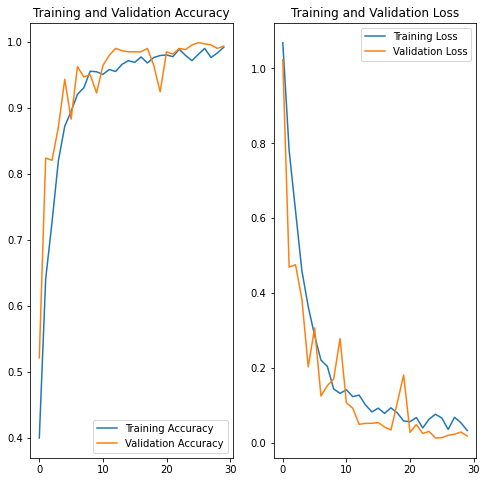

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference

Here below inference is executed.

3 inference sessions follow:

1. Run `predict` using a small test dataset stored in Kaggle
2. Run `evaluate` using the same dataset as in 1.
3. Run `predict` over interactively uploaded test images. 

**Upploa Kaggle Auth Token**

For above listed sessions 1 and 2, you need to download the test dataset from Kaggle. 

To do that, you need to upload the kaggle auth token (**kaggle.json** file). 

Find a detailed explaination on setting Kaggle API in [this post](https://ronen-halevy.github.io/2021/11/15/kaggle-api-settings.html).


In [ ]:
from google.colab import files

uploaded = files.upload()
  
# Move kaggle.json into ~/.kaggle:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


**Download the test dataset and unzip it**

In [ ]:
!kaggle datasets download -d ronenhalevy/rps-test
!unzip rps-test.zip

**Run Prediction over The Test Dataset**

In [ ]:
def do_prediction(image_folder):
    class_name=[]
    tf_image_data_array=[]   
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    cnt = 0
    for jdx, dir1 in enumerate(os.listdir(image_folder)):
        for idx, file in enumerate(os.listdir(os.path.join(image_folder, dir1))):
            cnt += 1
            ax = fig.add_subplot(6, 6, cnt) # this line adds sub-axe
            image= os.path.join(image_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (image_height,image_width))
            image = tf.cast(image / 255., tf.float32)
            ax.imshow(image)
            image = tf.expand_dims(image, axis=0)
            result=model.predict(tf.stack(image, axis=0))
            score = tf.nn.softmax(result)
            ax.set_title("{} {} {:#.4g}% "
              .format(cnt, class_names[np.argmax(score)],100 * np.max(score))
            )          
            ax.set_xticks([])
            ax.set_yticks([])
            class_name.append(dir1)                   
    return
img_folder='rps_test'
do_prediction(img_folder)


**Examine prediction results**

Results are much worse than the evaluation data results. Reason is obviously the too small sized training set.

Image #3 is a paper but detected a rock. Note that in training dataset, there is always a gap between papaers' fingers.

Image #11 are scissors but detected a rock. Reason might be the orientation, but anyway, a bigger training dataset might have performed better.



**Run Evaluate Over The Same Test Dataset** (And Expect the very same results)

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'rps_test',
  seed=123,
  image_size=(image_height, image_width),
  batch_size=3)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

results = model.evaluate(test_ds)

print(f'Test {model.metrics_names[0]}: {results[0]} / Test model.metrics_names[1]: {results[1]}')



**Run Prediction On Interactively uploaded Images**

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(image_height, image_width))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)